In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import re
import nethelp as nh
import powerlaw
from collections import Counter
import community
import pickle
import graph_tool.all as gt

In [2]:
def extract_years(date_string):
    """
    Extracts start and end years from a string formatted as 'YYYY - YYYY'.

    This function looks for a date range in the format 'YYYY - YYYY' within the given string.
    If found, it extracts and returns the start year and end year as integers.

    Parameters
    ----------
    date_string : str
        The string that may contain a date range in the 'YYYY - YYYY' format.

    Returns
    -------
    tuple or None
        A tuple containing two integers: (start_year, end_year) if the pattern is found.
        Returns None if the pattern is not found.

    Examples
    --------
    >>> extract_years("Event happened between 1995 - 2000")
    (1995, 2000)

    >>> extract_years("No date here")
    None
    """
    # Define a regex pattern for 'YYYY - YYYY'
    pattern = r'(\d{4})\s*-\s*(\d{4})'
    
    # Search for the pattern in the input string
    match = re.search(pattern, date_string)
    
    if match:
        # Extract the start and end years from the match groups
        start_year = int(match.group(1))
        end_year = int(match.group(2))
        return start_year, end_year
    else:
        return None  # Return None if no match is found


In [3]:
def parse_training_data(link_attributes, institution, order):
    """
    Parses a list of educational or training attributes to extract relevant details such as 
    degree level, subject, start year, end year, and awards. The function handles various 
    formats and patterns in the input data and applies specific rules based on the presence 
    of keywords like 'residency', 'fellowship', and 'class of', and adjusts for special cases 
    such as osteopathic institutions ('DO' degrees).

    Parameters:
    -----------
    link_attributes : list of str
        A list containing details about an individual's training or education at a particular 
        institution. Each entry can represent degree level, subject, year range, or other details.
        
    institution : str
        The name of the institution where the training or education took place. This is 
        checked for keywords such as 'osteopath' to infer specific degree levels like 'DO'.
        
    order : int
        An integer representing the order of the training or education in the individual's 
        trajectory, used for tracking sequence in a graph or timeline.

    Returns:
    --------
    dict
        A dictionary with the following keys:
        - 'level' : str or None
            The training level or degree (e.g., 'MD', 'PhD', 'Fellowship', 'Residency').
        - 'order' : int
            The order of the training or education, as passed in the input.
        - 'subject' : str or None
            The subject or field of study (e.g., 'Biology', 'Cardiology').
        - 'start' : int or None
            The start year of the training/education.
        - 'end' : int or None
            The end year of the training/education.
        - 'award' : str or None
            Any awards or honors mentioned (e.g., 'Cum Laude', 'Honors').

    Example:
    --------
    >>> parse_training_data(['Fellowship', 'Cardiology', '2005 - 2007'], 'Harvard University', 1)
    {'level': 'fellowship', 'order': 1, 'subject': 'cardiology', 'start': 2005, 'end': 2007, 'award': None}

    >>> parse_training_data(['Class of 2005'], 'NYIT College Of Osteopathic Medicine', 2)
    {'level': 'do', 'order': 2, 'subject': None, 'start': 2001, 'end': 2005, 'award': None}
    """
    level = None
    subject = None
    start_date = None
    end_date = None
    award = None 
    
    l = -1
    for entry in link_attributes:
        
        # training level 
        l = l + 1
        result = extract_years(entry)
        if 'class of' in entry.lower():
            level = 'md'
            # topic = None
            start_date = int(entry.split()[-1]) - 4
            end_date = int(entry.split()[-1])

        elif l == 0:

            if 'residency' in entry.lower():
                level = 'residency' 
                # start = start = int(entry.split()[-3]) # this needs to be its own if clause becuase the date is not going to be in the same entry as residency
                
            elif 'postdoc' in entry.lower().replace('-', ''):
                level = 'postdoc'
            
            elif 'fellowship' in entry.lower(): 
                level = 'fellowship'
            
            elif 'intern' in entry.lower():
                level = 'internship'

            elif 'intern' in entry.lower():
                level = 'internship'

            elif 'phd' in entry.lower().replace('.', ''):
                level = 'phd'

            elif 'mph' in entry.lower().replace('.', ''):
                level = 'mph'

            elif 'ba' in entry.lower().replace('.', ''):
                level = 'ba'
            
            elif 'bs' in entry.lower().replace('.', ''):
                level = 'bs'
            
            else:
                level = entry.lower().replace('.','')
        
        elif 'do' == entry.lower().replace('.',''):
            level = 'do'
        # start and end dates
        elif result:
            start_date, end_date = result
        
        # awards
        elif 'cum' in entry.lower():
            award = entry.lower()
        elif 'honor' in entry.lower() or 'honour' in entry.lower():
            award = entry.lower()

        # assume anything else is subject 
        else:
            subject = entry.lower()

    if 'osteopath' in institution.lower():
        level = 'do'
        
    parsed_dict = {
        'level': level,
        'order': order,
        'subject': subject,
        'start': start_date,
        'end': end_date,
        'award': award
    }
    return parsed_dict


In [10]:
i = -1
G = nx.Graph()
edge_count = 0
institutions = set()
# hospitals = set()
errors = 0
while i <= 38970: # total number of files
    i = i + 1 # increment counter
    try:
        filepath = '../../physician_trajectories/data/card/' + str(i) + '.json' # construct filepath
        with open(filepath, 'r') as f:
            data = json.load(f) # load json as dict
            G.add_node(i, 
                       bipartite = 0, 
                       first_name = data[str(i)]['first_name'],
                       last_name = data[str(i)]['last_name'],
                       specialty = data[str(i)]['specialty'],
                       sub_specialty = data[str(i)]['sub_specialty'],
                       office = data[str(i)]['office'],
                       job_titles = data[str(i)]['job_titles'],
                       awards = data[str(i)]['awards'])

            if data.get(str(i)).get('training'):
                for keys, vals in data.get(str(i)).get('training').items(): # iterate through 'training'
                    inst = list(vals.keys())[0]
                    institutions.add(inst) # add institution to set
                    parsed_dict = parse_training_data(link_attributes=list(vals.values())[0], institution=inst, order=int(keys))
                    # create edge between doctor id and institution
                    G.add_node(inst, bipartite = 1) # hopefully add university metadata here
                    G.add_edge(
                        i, 
                        inst, 
                        level = parsed_dict['level'], 
                        order = parsed_dict['order'], 
                        subject = parsed_dict['subject'], 
                        start = parsed_dict['start'], 
                        end = parsed_dict['end'], 
                        award = parsed_dict['award']
                    )
                for line in data.get(str(i)).get('hospital'):
                    institutions.add(line) # add hospital to set
                    G.add_node(line, bipartite = 1)
                    G.add_edge(i, line) # create edge between doctor and hospital
    except Exception as e:
        # todo: make more informative error handling
        errors = errors + 1

g_card = G

In [5]:
errors

432

In [11]:
i = -1
G = nx.Graph()
edge_count = 0
institutions = set()
# hospitals = set()
errors = 0
while i <= 10964: # total number of files
    i = i + 1 # increment counter
    try:
        filepath = '../../physician_trajectories/data/geriatrics/' + str(i) + '.json' # construct filepath
        with open(filepath, 'r') as f:
            data = json.load(f) # load json as dict
            G.add_node(i, 
                       bipartite = 0, 
                       first_name = data[str(i)]['first_name'],
                       last_name = data[str(i)]['last_name'],
                       specialty = data[str(i)]['specialty'],
                       sub_specialty = data[str(i)]['sub_specialty'],
                       office = data[str(i)]['office'],
                       job_titles = data[str(i)]['job_titles'],
                       awards = data[str(i)]['awards'])

            if data.get(str(i)).get('training'):
                for keys, vals in data.get(str(i)).get('training').items(): # iterate through 'training'
                    inst = list(vals.keys())[0]
                    institutions.add(inst) # add institution to set
                    parsed_dict = parse_training_data(link_attributes=list(vals.values())[0], institution=inst, order=int(keys))
                    # create edge between doctor id and institution
                    G.add_node(inst, bipartite = 1) # hopefully add university metadata here
                    G.add_edge(
                        i, 
                        inst, 
                        level = parsed_dict['level'], 
                        order = parsed_dict['order'], 
                        subject = parsed_dict['subject'], 
                        start = parsed_dict['start'], 
                        end = parsed_dict['end'], 
                        award = parsed_dict['award']
                    )
                for line in data.get(str(i)).get('hospital'):
                    institutions.add(line) # add hospital to set
                    G.add_node(line, bipartite = 1)
                    G.add_edge(i, line) # create edge between doctor and hospital
    except Exception as e:
        # todo: make more informative error handling
        errors = errors + 1

g_ger = G

In [7]:
errors

40

In [10]:
nx.is_bipartite(g_ger)

True

In [5]:
g_ger.number_of_nodes()

16079

In [12]:
def bipartite_degrees(B, number_of_bins=15, log_binning_0=True, log_binning_1 = True, density=True):

    group_0_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
    group_1_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}

    group_0_degrees = [B.degree(n) for n in group_0_nodes]
    group_1_degrees = [B.degree(n) for n in group_1_nodes]

    # Step 1: We will first need to define the support of our distribution
    kmax_0 = np.max(group_0_degrees)  # get the maximum degree
    kmax_1 = np.max(group_1_degrees)  # get the maximum degree
    kmin_0 = np.min(group_0_degrees)  # 
    kmin_1 = np.min(group_1_degrees)  # 

    # Step 2: Then we'll need to construct bins
    if log_binning_0:
        # array of bin edges including rightmost and leftmost
        bins = np.logspace(0, np.log10(kmax_0 + 1), number_of_bins + 1)
    else:
        bins = np.linspace(0, kmax_0 + 1, num=number_of_bins + 1)

    # Step 3: Then we can compute the histogram using numpy
    probs_0, _ = np.histogram(group_0_degrees, bins, density=density)
    bins_out_0 = bins[1:] - np.diff(bins) / 2.0

    # Step 2: Then we'll need to construct bins
    if log_binning_1:
        # array of bin edges including rightmost and leftmost
        bins = np.logspace(0, np.log10(kmax_1 + 1), number_of_bins + 1)
    else:
        bins = np.linspace(0, kmax_1 + 1, num=number_of_bins + 1)

    # Step 3: Then we can compute the histogram using numpy
    probs_1, _ = np.histogram(group_1_degrees, bins, density=density)    

    # Step 4: Return not the "bins" but the midpoint between adjacent bin
    #         values. This is a better way to plot the distribution.
    bins_out_1 = bins[1:] - np.diff(bins) / 2.0

    return bins_out_0, probs_0, bins_out_1, probs_1, group_0_degrees, group_1_degrees

2.168523233523881
36.0
2.168523233523881
36.0


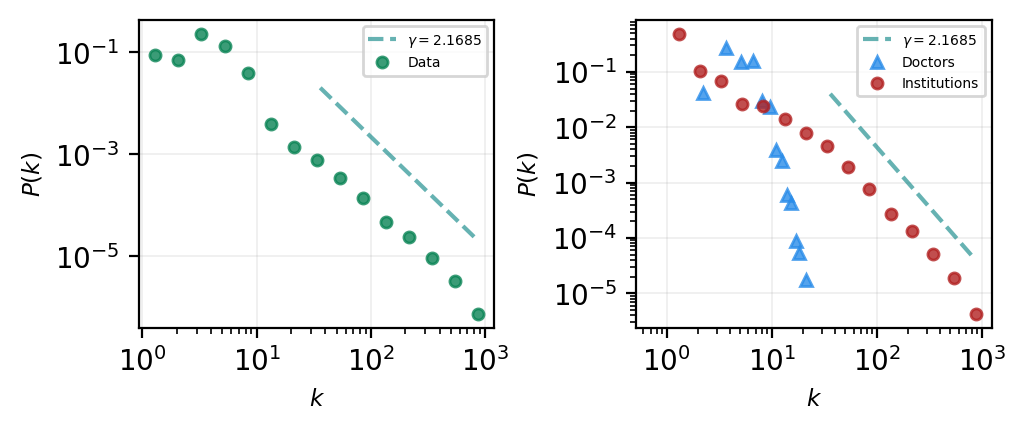

In [15]:
x, y = nh.distributions.degree_distribution(g_card)
fig, ax = plt.subplots(1,2,figsize=(5.5,2),dpi=200)

degree_sequence = np.array(list(dict(g_card.degree()).values()))
results = powerlaw.Fit(degree_sequence,verbose=False);
print(results.power_law.alpha)
print(results.power_law.xmin)

xvals = np.linspace(results.power_law.xmin, max(degree_sequence)*0.75)
slope_line = xvals ** (- results.power_law.alpha)
slope_line = slope_line/sum(slope_line)*0.05

ax[0].loglog(xvals, slope_line, label=r'$\gamma = %.4f$'%results.power_law.alpha,ls='--',color='teal', alpha = 0.6)

ax[0].loglog(x, y,'o', color='#0a8455', alpha=0.8,  ms = 4, label = 'Data')

ax[0].set_xlabel(r"$k$",fontsize='small')
ax[0].set_ylabel(r"$P(k)$",fontsize='small')
ax[0].grid(linewidth=0.7, color='#999999', alpha=0.15, linestyle='-')
# ax[0].set_title('Degree Distribution')
ax[0].legend(fontsize=5)

x0,y0,x1,y1,degs_0,degs_1 = bipartite_degrees(g_card, log_binning_0=False, log_binning_1=True)

results = powerlaw.Fit(degs_1,verbose=False);
print(results.power_law.alpha)
print(results.power_law.xmin)

xvals = np.linspace(results.power_law.xmin, max(degree_sequence)*0.75)
slope_line = xvals ** (- results.power_law.alpha)
slope_line = slope_line/sum(slope_line)*0.1

ax[1].loglog(xvals, slope_line, label=r'$\gamma = %.4f$'%results.power_law.alpha,ls='--',color='teal', alpha = 0.6)
ax[1].loglog(x0, y0,'^', color='#298ce9', alpha=0.8,  ms = 4, label = 'Doctors')

ax[1].set_xlabel(r"$k$",fontsize='small')
ax[1].set_ylabel(r"$P(k)$",fontsize='small')

ax[1].loglog(x1, y1,'o', color='firebrick', alpha=0.8,  ms = 4, label = 'Institutions')

ax[1].grid(linewidth=0.7, color='#999999', alpha=0.15, linestyle='-')
ax[1].legend(fontsize=5)

plt.subplots_adjust(wspace=0.40, hspace=0.05)

# plt.savefig('../figs/degree_dist.pdf', dpi=425, bbox_inches='tight')
plt.savefig('../figs/degree_dist_card.png', dpi=425, bbox_inches='tight')

2.3230955354393927
8.0
2.250914572711875
10.0


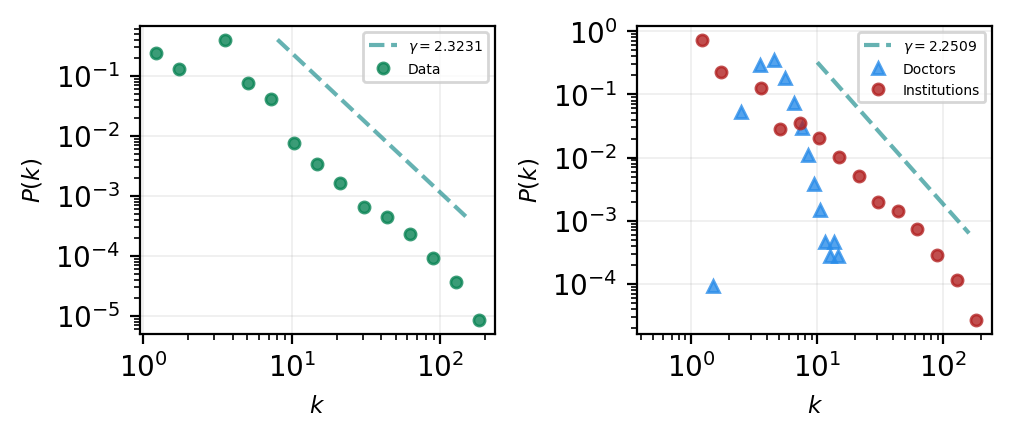

In [17]:
x, y = nh.distributions.degree_distribution(g_ger)
fig, ax = plt.subplots(1,2,figsize=(5.5,2),dpi=200)

degree_sequence = np.array(list(dict(g_ger.degree()).values()))
results = powerlaw.Fit(degree_sequence,verbose=False);
print(results.power_law.alpha)
print(results.power_law.xmin)

xvals = np.linspace(results.power_law.xmin, max(degree_sequence)*0.75)
slope_line = xvals ** (- results.power_law.alpha)
slope_line = slope_line/sum(slope_line)#*0.05

ax[0].loglog(xvals, slope_line, label=r'$\gamma = %.4f$'%results.power_law.alpha,ls='--',color='teal', alpha = 0.6)

ax[0].loglog(x, y,'o', color='#0a8455', alpha=0.8,  ms = 4, label = 'Data')

ax[0].set_xlabel(r"$k$",fontsize='small')
ax[0].set_ylabel(r"$P(k)$",fontsize='small')
ax[0].grid(linewidth=0.7, color='#999999', alpha=0.15, linestyle='-')
# ax[0].set_title('Degree Distribution')
ax[0].legend(fontsize=5)

x0,y0,x1,y1,degs_0,degs_1 = bipartite_degrees(g_ger, log_binning_0=False, log_binning_1=True)

results = powerlaw.Fit(degs_1,verbose=False);
print(results.power_law.alpha)
print(results.power_law.xmin)

xvals = np.linspace(results.power_law.xmin, max(degree_sequence)*0.75)
slope_line = xvals ** (- results.power_law.alpha)
slope_line = slope_line/sum(slope_line)#*0.1

ax[1].loglog(xvals, slope_line, label=r'$\gamma = %.4f$'%results.power_law.alpha,ls='--',color='teal', alpha = 0.6)
ax[1].loglog(x0, y0,'^', color='#298ce9', alpha=0.8,  ms = 4, label = 'Doctors')

ax[1].set_xlabel(r"$k$",fontsize='small')
ax[1].set_ylabel(r"$P(k)$",fontsize='small')

ax[1].loglog(x1, y1,'o', color='firebrick', alpha=0.8,  ms = 4, label = 'Institutions')

ax[1].grid(linewidth=0.7, color='#999999', alpha=0.15, linestyle='-')
ax[1].legend(fontsize=5)

plt.subplots_adjust(wspace=0.40, hspace=0.05)

# plt.savefig('../figs/degree_dist_ger.pdf', dpi=425, bbox_inches='tight')
plt.savefig('../figs/degree_dist_ger.png', dpi=425, bbox_inches='tight')

In [21]:
nx.number_connected_components(g_ger)

In [27]:
# Find all connected components
connected_components = list(nx.connected_components(g_ger))

# Get the largest connected component
largest_component = max(connected_components, key=len)

# Create a subgraph for the largest component
largest_component_subgraph = G.subgraph(largest_component)

# Print the largest component
print("Largest connected component:", largest_component)
print("Size of largest connected component:", len(largest_component))

Largest connected component: {'Methodist Hospital (Houston)', 2, 3, 'Juan N. Corpas School of Medicine', 5, 'Cheyenne Regional Medical Center', 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 'Philadelphia Veterans Affairs Medical Center', 22, 24, 25, 26, 27, 28, 29, 30, 31, 'University of Southampton Faculty of Medicine', 33, 34, 35, 36, 'Carteret Health Care', 38, 39, 40, 41, 'Grady Health System', 42, 44, 45, 46, 43, 48, 49, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, "St Joseph's University Medical School", 'Kaiser Permanente San Rafael Medical Center', 64, 65, 66, 'Silas B Hays Army Community Hospital', 68, 69, 'Baylor Medical Center at Garland', 71, 72, 73, 'Boston Medical Center', 74, 76, 77, 78, 79, 80, 75, 82, 81, 84, 83, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 'Kaiser Permanente Roseville Medical Center', 'HCA South Atlantic - Memorial Health', 99, 100, 101, 102, 103, 'Allegheny Health Network Medical Education Consortium (SVH)', 105, 106, 107, 108, 109, 'Sou

In [33]:
B = largest_component_subgraph.copy()
doctors, institutions = nx.bipartite.sets(B)
projection_institutions = nx.bipartite.projected_graph(B, nodes= institutions, multigraph=True)
projection_doctors = nx.bipartite.projected_graph(B, nodes= doctors, multigraph=True)

In [34]:
weighted_projection_institutions = nx.Graph()
for u,v,data in projection_institutions.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if weighted_projection_institutions.has_edge(u,v):
        weighted_projection_institutions[u][v]['weight'] += w
    else:
        weighted_projection_institutions.add_edge(u, v, weight=w)

In [17]:
def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    # if isinstance(key, unicode):
    #     # Encode the key as ASCII
    #     key = key.encode('ascii', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    # elif isinstance(value, unicode):
    #     tname = 'string'
    #     value = value.encode('ascii', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

In [35]:
gt_weighted_inst = nx2gt(weighted_projection_institutions)

In [37]:
g = gt_weighted_inst
y = g.ep.weight.copy()
y.a = np.log(y.a)

state_ln = gt.minimize_nested_blockmodel_dl(g, state_args=dict(recs=[y], rec_types=["real-normal"]))

In [41]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Assume the graph has an edge property "weight"
if "weight" in g.ep:
    edge_weights = g.ep["weight"]
else:
    raise ValueError("The graph does not have an edge weight property.")

# Calculate weighted degree for each vertex
weighted_degrees = g.new_vertex_property("double")
for v in g.vertices():
    weighted_degrees[v] = sum(edge_weights[e] for e in v.all_edges())

# Normalize the weighted degree to a suitable range for vertex size
vertex_size = gt.prop_to_size(weighted_degrees, mi=2, ma=5, power=1)

# Normalize the edge weights to [0, 1] for colormap application
norm = mcolors.Normalize(vmin=min(edge_weights.a), vmax=max(edge_weights.a))
min_width, max_width = 0.03, 1
edge_widths = g.new_edge_property("double")

# Apply the inferno colormap
cmap = cm.get_cmap('inferno')
edge_colors = g.new_edge_property("vector<double>")  # To store the RGB colors

for e in g.edges():
    weight = edge_weights[e]
    if weight > 2:  # Only process edges with weight greater than 10
        color = cmap(norm(weight))  # Map the weight to a color using the colormap
        edge_colors[e] = color[:3]  # Store the RGB part of the color (exclude alpha)
        edge_widths[e] = 2.5*norm(weight) * (max_width - min_width) + min_width    
    else:
        edge_colors[e] = (1, 1, 1, 0)  # Make the color transparent if weight <= 10
        edge_widths[e] = 0  # Set width to 0 to effectively hide the edge

# # Set drawing parameters
dprms = dict(fmt="png", output_size=(900, 900))

pos2 = gt.sfdp_layout(g, groups=state_ln.levels[3].b, gamma=.04) 

state_ln.levels[3].draw(
    pos=pos2, edge_gradient=[], edge_color=edge_colors, #ecmap=(cm.inferno, .9), 
    eorder=edge_widths, edge_pen_width=edge_widths, vertex_size=vertex_size, **dprms
)

<positron-console-cell-41>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


In [40]:
state_ln.print_summary()

l: 0, N: 5150, B: 674
l: 1, N: 674, B: 297
l: 2, N: 297, B: 214
l: 3, N: 214, B: 11
l: 4, N: 11, B: 8
l: 5, N: 8, B: 2
l: 6, N: 2, B: 1
l: 7, N: 1, B: 1


In [ ]:
3+4